<a href="https://colab.research.google.com/github/AkshatBhatnagar29/Assg2-Topsis-on-Pretrained-Models/blob/main/Topsis_on_Pretrained_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q sentence-transformers scikit-learn pandas numpy scipy torch


In [3]:
import time
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from datasets import load_dataset

print("Loading STS Benchmark dataset...")
sts = load_dataset("glue", "stsb", split="validation")


models_list = [
    'sentence-transformers/all-MiniLM-L6-v2',
    'sentence-transformers/all-mpnet-base-v2',
    'sentence-transformers/paraphrase-MiniLM-L6-v2',
    'sentence-transformers/multi-qa-MiniLM-L6-cos-v1',
    'sentence-transformers/all-distilroberta-v1'
]

Loading STS Benchmark dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

stsb/train-00000-of-00001.parquet:   0%|          | 0.00/502k [00:00<?, ?B/s]

stsb/validation-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

stsb/test-00000-of-00001.parquet:   0%|          | 0.00/114k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [4]:
df = pd.DataFrame(sts)

df["label"] = df["label"] / 5.0

df.head()


,sentence1,sentence2,label,idx
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,1.00,0
1,A young child is riding a horse.,A child is riding a horse.,0.95,1
2,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,1.00,2
3,A woman is playing the guitar.,A man is playing guitar.,0.48,3
4,A woman is playing the flute.,A man is playing a flute.,0.55,4


In [5]:
results = []

for model_id in models_list:
    model_name = model_id.split("/")[-1]
    print(f"\nEvaluating model: {model_name}")

    model = SentenceTransformer(model_id)

    start_time = time.time()

    # Batch encode sentences
    sentences1 = df["sentence1"].tolist()
    sentences2 = df["sentence2"].tolist()

    embeddings1 = model.encode(
        sentences1,
        batch_size=32,
        convert_to_numpy=True,
        show_progress_bar=True
    )

    embeddings2 = model.encode(
        sentences2,
        batch_size=32,
        convert_to_numpy=True,
        show_progress_bar=True
    )

    # Cosine similarity (vectorized)
    model_scores = np.sum(embeddings1 * embeddings2, axis=1) / (
        np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
    )

    elapsed_time = time.time() - start_time
    avg_time = elapsed_time / len(df)

    # Correlation with human scores
    pearson = pearsonr(model_scores, df["label"])[0]
    spearman = spearmanr(model_scores, df["label"])[0]

    embedding_dim = model.get_sentence_embedding_dimension()

    results.append([
        model_name,
        pearson,
        spearman,
        avg_time,
        embedding_dim
    ])



Evaluating model: all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]


Evaluating model: all-mpnet-base-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]


Evaluating model: paraphrase-MiniLM-L6-v2


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]


Evaluating model: multi-qa-MiniLM-L6-cos-v1


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]


Evaluating model: all-distilroberta-v1


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

In [10]:
decision_matrix = pd.DataFrame(
    results,
    columns=["Model", "Pearson", "Spearman", "Avg_Time", "Embedding_Dim"]
)

decision_matrix


,Model,Pearson,Spearman,Avg_Time,Embedding_Dim
0,all-MiniLM-L6-v2,0.869619,0.867163,0.025068,384
1,all-mpnet-base-v2,0.880625,0.881090,0.160953,768
2,paraphrase-MiniLM-L6-v2,0.869475,0.870504,0.023696,384
3,multi-qa-MiniLM-L6-cos-v1,0.794655,0.804605,0.022542,384
4,all-distilroberta-v1,0.882934,0.882978,0.076215,768


In [12]:
model_sizes = {
    "all-MiniLM-L6-v2": 90,
    "all-mpnet-base-v2": 420,
    "paraphrase-MiniLM-L6-v2": 90,
    "multi-qa-MiniLM-L6-cos-v1": 90,
    "all-distilroberta-v1": 305
}

decision_matrix["Model_Size_MB"] = decision_matrix["Model"].map(model_sizes)
decision_matrix


,Model,Pearson,Spearman,Avg_Time,Embedding_Dim,Model_Size_MB
0,all-MiniLM-L6-v2,0.869619,0.867163,0.025068,384,90
1,all-mpnet-base-v2,0.880625,0.881090,0.160953,768,420
2,paraphrase-MiniLM-L6-v2,0.869475,0.870504,0.023696,384,90
3,multi-qa-MiniLM-L6-cos-v1,0.794655,0.804605,0.022542,384,90
4,all-distilroberta-v1,0.882934,0.882978,0.076215,768,305


In [13]:
topsis_data = decision_matrix.drop(columns=["Model"]).values

weights = np.array([0.3, 0.3, 0.15, 0.1, 0.15])

impacts = ['+', '+', '-', '-', '-']


In [14]:
norm = topsis_data / np.sqrt((topsis_data ** 2).sum(axis=0))
weighted = norm * weights


In [15]:
ideal_best = []
ideal_worst = []

for i, imp in enumerate(impacts):
    if imp == '+':
        ideal_best.append(weighted[:, i].max())
        ideal_worst.append(weighted[:, i].min())
    else:
        ideal_best.append(weighted[:, i].min())
        ideal_worst.append(weighted[:, i].max())

ideal_best = np.array(ideal_best)
ideal_worst = np.array(ideal_worst)


In [16]:
dist_best = np.sqrt(((weighted - ideal_best) ** 2).sum(axis=1))
dist_worst = np.sqrt(((weighted - ideal_worst) ** 2).sum(axis=1))

topsis_score = dist_worst / (dist_best + dist_worst)

decision_matrix["TOPSIS_Score"] = topsis_score
decision_matrix["Rank"] = decision_matrix["TOPSIS_Score"].rank(ascending=False)

decision_matrix.sort_values("Rank")


,Model,Pearson,Spearman,Avg_Time,Embedding_Dim,Model_Size_MB,TOPSIS_Score,Rank
2,paraphrase-MiniLM-L6-v2,0.869475,0.870504,0.023696,384,90,0.980174,1.0
0,all-MiniLM-L6-v2,0.869619,0.867163,0.025068,384,90,0.974779,2.0
3,multi-qa-MiniLM-L6-cos-v1,0.794655,0.804605,0.022542,384,90,0.889983,3.0
4,all-distilroberta-v1,0.882934,0.882978,0.076215,768,305,0.495963,4.0
1,all-mpnet-base-v2,0.880625,0.881090,0.160953,768,420,0.107538,5.0


In [17]:
best_model = decision_matrix.sort_values("Rank").iloc[0]
best_model


,2
Model,paraphrase-MiniLM-L6-v2
Pearson,0.869475
Spearman,0.870504
Avg_Time,0.023696
Embedding_Dim,384
Model_Size_MB,90
TOPSIS_Score,0.980174
Rank,1.0


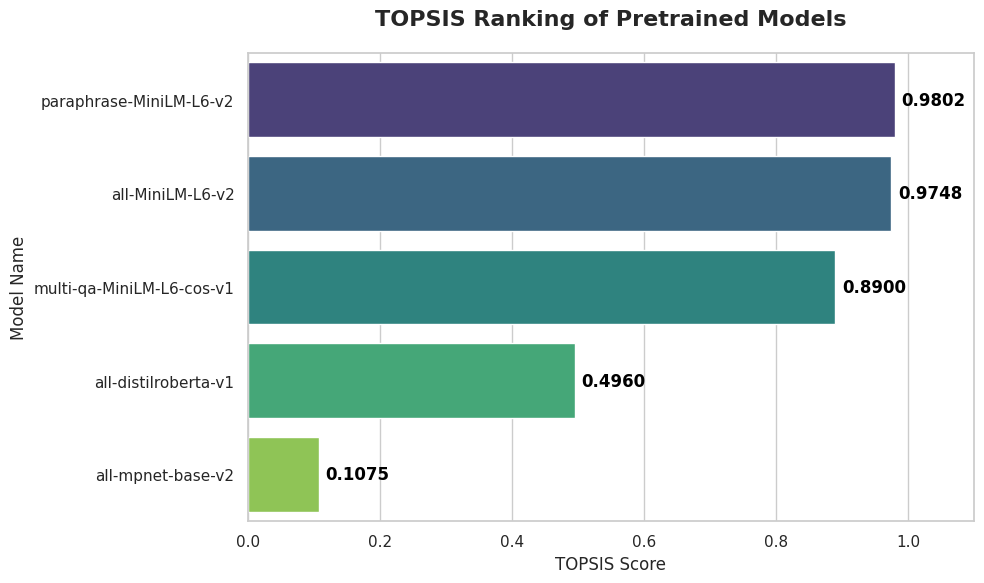

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Create the dataset based on your result table
data = {
    'Model': [
        'paraphrase-MiniLM-L6-v2',
        'all-MiniLM-L6-v2',
        'multi-qa-MiniLM-L6-cos-v1',
        'all-distilroberta-v1',
        'all-mpnet-base-v2'
    ],
    'TOPSIS_Score': [0.980174, 0.974779, 0.889983, 0.495963, 0.107538]
}

df = pd.DataFrame(data)

# 2. Sort data to have the highest score on the left
df = df.sort_values(by='TOPSIS_Score', ascending=False)

# 3. Create the plot
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Create the bar plot
# We use a color palette that highlights the top ranks
barplot = sns.barplot(
    x='TOPSIS_Score',
    y='Model',
    data=df,
    palette='viridis',
    hue='Model',
    legend=False
)

# 4. Add labels and title
plt.title('TOPSIS Ranking of Pretrained Models', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('TOPSIS Score', fontsize=12)
plt.ylabel('Model Name', fontsize=12)
plt.xlim(0, 1.1)  # Set x-axis limit slightly above 1 for spacing

# 5. Add the score text at the end of each bar for clarity
for i, v in enumerate(df['TOPSIS_Score']):
    barplot.text(v + 0.01, i, f"{v:.4f}", va='center', fontweight='bold', color='black')

# 6. Save or Show the plot
plt.tight_layout()
plt.savefig('topsis_ranking_graph.png', dpi=300) # Saves high-res image
plt.show()